In [1]:
from numba import jit, njit

import numpy as np
import scipy
import math
from numpy.linalg import inv #routine to invert matrix
import matplotlib.pyplot as plt
from qutip import *
import time
import sys
from scipy.interpolate import interp1d
from scipy.special import factorial

import kwant

import Lattices as ltt
import DispersionHopping as dh

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:

def effVdis(Nx, Ny, R, dr, xic, xi0):
    Vdis = np.zeros(shape=(Nx*Ny, Nx*Ny), dtype=np.complex_)
    Vxy = np.zeros(shape=(Nx, Ny), dtype=np.complex_)


    #Vxy = np.power(1.5, 3.)*(2*np.random.rand(Nx, Ny) - 1.)
    Vxy = np.random.normal(0, 1., size=(Nx, Ny))/(dr)

    kVxy = np.fft.fft2(Vxy)
    kx = np.zeros(shape=(Nx, 1), dtype=np.complex_)
    ky = np.zeros(shape=(1, Ny), dtype=np.complex_)
    ix = np.zeros(shape=(1, Nx), dtype=np.complex_)
    iy = np.zeros(shape=(Ny, 1), dtype=np.complex_)
    kx[:,0] = 2*np.pi * np.fft.fftfreq(kVxy.shape[0],d=dr)
    ky[0,:] = 2*np.pi * np.fft.fftfreq(kVxy.shape[1],d=dr)
    ix[0,:] =  np.ones(Nx)
    iy[:,0] =  np.ones(Ny)
    k2 = np.matmul(np.square(kx), ix) + np.matmul(iy, np.square(ky))

    norm = np.sqrt(2.)/xic
    kVxy = xi0 * np.multiply(kVxy, np.exp( - .125*xic*xic*k2 ) )/norm
    #norm = np.sqrt(np.sum(np.square(Vxy))/(1.*Nx*Ny))

    #norm = 2./xic*np.sqrt(np.sqrt(np.pi/4.))
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)

    Vdis = np.diag( Vxy.flatten('F') )

    """
    idx = kx[:,0].argsort()[::-1]
    idx = np.flip(idx)
    idy = ky[0, :].argsort()[::-1]
    idy = np.flip(idy)
    kx = kx[idx,:]
    ky = ky[:, idy]
    kVxy = kVxy[:,idy]
    kVxy = kVxy[idx,:]
    p_kVdis = open("data/kvdis.dat", "w")
    p_Vdis = open("data/vdis.dat", "w")
    n = 0
    for ny in range(Ny):
        for nx in range(Nx):
            p_kVdis.write("%f %f %f\n" % (kx[nx][0].real, ky[0][ny].real, np.abs(kVxy[nx][ny]) ))
            p_Vdis.write("%f %f %f\n" % (R[0][n]*dr, R[1][n]*dr, Vxy[nx][ny].real ))
            p_kVdis.flush()
            p_Vdis.flush()
            n += 1
        p_Vdis.write("\n")
        p_Vdis.flush()
        p_kVdis.write("\n")
        p_kVdis.flush()
    """

    return Vdis


def corr_dis(L, W, a, xic):
    Nx = int(L/a)
    Ny = int(W/a)
    Vxy = np.random.normal(0, 1., size=(Ny, Nx))/(a) + 1j*0.0
    
    kkVxy = np.fft.fft2(Vxy)
    kx = 2*np.pi * np.fft.fftfreq(kkVxy.shape[1],d=a)
    ky = 2*np.pi * np.fft.fftfreq(kkVxy.shape[0],d=a)
    kx, ky = np.meshgrid(kx,ky)
    
    kVxy = np.multiply(kkVxy, np.exp( - .125 * (xic)**2. * (kx**2.+ky**2.)  ) ) * (xic)/np.sqrt(2.)
    #kVxy = np.divide(kkVxy, np.sqrt( (kx**2.+ky**2.) + (1/xic)**2./4.  ) )*np.sqrt(1./xic/(2*np.pi))
    
    #xlong = W/4.
    #xavg = (xic + xlong)/2.
    #kVxy = np.multiply(kkVxy, np.exp( - .125**3. * xic**4. * (kx**4.+ky**4.)  ) ) * (xavg/2.)/np.sqrt(2.)
    #kVxy += np.multiply(kkVxy, np.exp( - .125 * (xlong)**2. * (kx**2.+ky**2.)  ) ) * (xavg/2.)/np.sqrt(2.)
    
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)
    
    Vdis = np.diag( Vxy.flatten('F') )

    return Vdis

In [3]:

def v_img(d, zrange, N):
    arr_V = []
    arr_z = np.linspace(-zrange, zrange, N)
    for z in arr_z:
        V = 0
        nf = 10000
        n_Z = np.linspace( -nf, nf, 2*nf+1)
        for n in n_Z:
            if n != 0:
                V += ( 1./(2*np.abs(n)) - 1./(2.*np.abs(n+z/d + .0000001)) )
        if z < 0:
            arr_V.append(V)
        else:
            arr_V.append(V)
    return arr_z, arr_V  

def v_img_singleside(lB, R, min_l):
    arr_V = - 1./(2*np.abs( 2*(np.amax(R[:,0])-R[:,0]+min_l)/lB + .000001 ))
    return arr_V  


#dd= 60.  
#arr_z, arr_V = v_img(dd+.1, dd, 100)  
#arr_z, arr_V = v_img_singleside(15, dd, 100, .1)  
#plt.plot(arr_z, np.asarray(arr_V)/dd + 0*(arr_z/30.)**4)
#plt.plot(arr_z, - arr_z**2/(dd)**2/(dd-10) )
#plt.ylim((-.001,.0))
#plt.xlim((-10,10))

In [4]:

def tan_confinement(Nx, Ny, R, dr, Ledge, A):
    Vxy = np.zeros(shape=(Ny, Nx), dtype=np.complex_)
    Vflat = np.zeros(shape=(Ny*Nx), dtype=np.complex_)
    Nedge = int(Ledge/dr)
    xvec = np.linspace(0, Nx-1, int(Nx) )
    yvec = np.linspace(0, Ny-1, int(Ny) )    
    
    
    minRx = np.amin(xvec)
    maxRx = np.amax(xvec)
    count = 0
    for ny in range(Ny):
        for nx in range(Nx):
            if xvec[nx] <= (Ledge + minRx):
                Vxy[ny][nx] = (np.tan(A * np.pi/2.*( xvec[nx] - (Ledge + minRx) )/Ledge  ) )**2.
                Vflat[count] = (np.tan(A * np.pi/2.*( xvec[nx] - (Ledge + minRx) )/Ledge  ) )**2.
            elif xvec[nx] >= (maxRx-(Ledge)):
                Vxy[ny][nx] = (np.tan(A * np.pi/2.*( yvec[nx] - (maxRx-(Ledge) + dr/2.  ) )/Ledge  ) )**2.
                Vflat[count] = (np.tan(A * np.pi/2.*( yvec[nx] - (maxRx-(Ledge) + dr/2.  ) )/Ledge  ) )**2.
            count += 1
    return Vxy, Vflat

Nx = 50
Ny = 30

Vconf, Vconf_flat = tan_confinement(Nx, Ny, R, 1., Ny/20, .6)

xvec = np.linspace(0, Nx-1, int(Nx) )
yvec = np.linspace(0, Ny-1, int(Ny) )
X, Y = np.meshgrid(xvec, yvec)

fig_conf, ax_conf = plt.subplots(dpi=120, figsize=(8, 4))

vmin = -1.
vmax = 1.000
conf_plot = ax_conf.pcolormesh(X*l0, Y*l0, np.log(Vconf.real)/np.log(10), cmap='gist_heat', alpha=1, vmin=vmin, vmax=vmax)

fig_conf.colorbar(conf_plot)

ax_conf.set_xlabel(r'$x$ - micron')
ax_conf.set_ylabel(r'$y$ - micron')
ax_conf.set_aspect('equal')
print(np.amax(Vconf) )

NameError: name 'R' is not defined

In [4]:
Nx = 100
Ny = 100
R, M = ltt.square_lattice( Nx, Ny, 1 )


BandW0 = 40*1   #total bandwidth in meV
l0 = np.sqrt(568/BandW0*8.) * 10**(-3.) # sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
B0 = 4.14*10**3. / (l0 * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2

J = 1.
alpha = 1./80.
lB = 1./np.sqrt(2*np.pi*alpha)
omB = 4*np.pi*alpha*J
omB_0 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. )
omB_1 = omB - (4*np.pi*alpha*J)**2./(32.*J)*(2*1**2. + 2.*1 + 1. )
omega_0 = 4*J
xic = 4
dis = .1/BandW0*8 *0
IMG = (1.44/BandW0*8)/(lB*l0) * 0

l_B = lB*l0

omega_ = dh.disp_flat_emitters(omega_0, M, 0)


E = (omB_1-omB_0)/Nx * 200.
omegaE = dh.ph_electric_field(E, M, R)
omegaE = omegaE - np.amin(omegaE)
#omegaDis = effVdis(Nx, Ny, R, 1, xic, dis)
omegaDis = corr_dis(Nx, Ny, 1, xic)
omegaDis = omegaDis*dis

Conf = np.abs(omB_1-omB_0) * 60000.
omega_conf = dh.ph_confinement(Conf, M, 6, R)

plate_distance = 3
epsilon = 10.
#arr_z, Vimg = v_img(W/2.+plate_distance, W/2., int(W))
Vimg = v_img_singleside(lB, R, plate_distance)

Vimg = Vimg/epsilon

#Vconf, Vconf_flat = tan_confinement(Nx, Ny, R, 1., Ny/15, .6)
#conf_A = 0.

#V = dh.hopping_matrix_HH( J, R, M, alpha )
#V = dh.PBC_hopping_matrix_HH( J, R, M, Nx, Ny, alpha, 0 )
V = dh.PBC_hopping_matrix_HH( J, R, M, Nx, Ny, alpha, 0 )
#V = dh.inhomo_hopping_matrix_HH( J, R, M, alpha_vec )


H = np.diag(omega_*0+omegaE+Vimg*IMG*0 + omega_conf) + V + omegaDis

evals, evecs = np.linalg.eig(H)
idx = np.argsort(evals)
evals = evals[idx]
evecs = evecs[:,idx]
#evals = evals - evals[0]

99.0 99.0


In [5]:
print(E/omB_1*lB, Conf/Nx**6/omB_1*lB**6)

-0.14365049397684082 2.492893212114255e-06


In [6]:
print(omB, lB, Nx*Ny/lB**2./(2*np.pi))

0.15707963267948966 3.568248232305542 125.00000000000003


In [7]:
XXX = np.matmul( np.conj(evecs.T), np.matmul(np.diag(R[:,0]), evecs) )

YYY = np.matmul( np.conj(evecs.T), np.matmul(np.diag((R[:,0]-Nx/2.)**2.), evecs) )


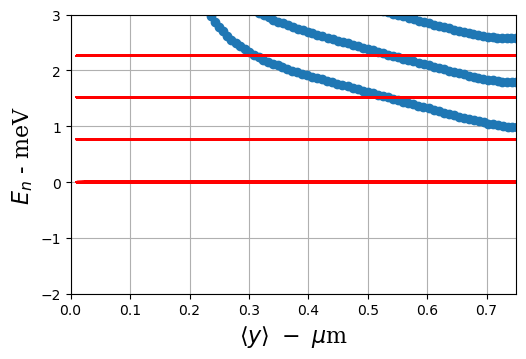

In [8]:
omB_00 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. )
omB_0 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_1 = omB - (4*np.pi*alpha*J)**2./(32.*J)*(2*1**2. + 2.*1 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_2 = omB*2 - (4*np.pi*alpha*J)**2./(32.*J)*(2*2**2. + 2.*2 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_3 = omB*3 - (4*np.pi*alpha*J)**2./(32.*J)*(2*3**2. + 2.*3 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

mid_y = np.amax(np.abs(np.diagonal(XXX)))/2.*0

plt.figure(figsize=(16, 8))

plt.plot( (np.abs(np.diagonal(XXX)) -mid_y)*l0, (evals.real + 4*J - omB_00/2.)*BandW0/8, linestyle='none', marker='o')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_3)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_2)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_1)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(0)*BandW0/8, color='red', linestyle='-')
#plt.plot(Xvec, evals.real, linestyle='none', marker='o')
plt.xlim((-.0, .75 ))
plt.ylim((-2.,3))
plt.grid()

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel(r'$\langle{ y \rangle} ~ - ~ \mu$m', fontdict=font)
plt.ylabel(r'$E_n$ - meV', fontdict=font)


plt.tight_layout()
plt.gcf().set_size_inches(120 / 25.4, 80 / 25.4)
#plt.savefig('LL_IMG%.2f_dis%.2f_xic%.2f_BW%.2f_alpha%.2f_Nx%dNy%d.svg' % (IMG, dis, xic, BandW0, alpha, Nx, Ny))
#plt.savefig('LL_IMG%.2f_dis%.2f_xic%.2f_BW%.2f_alpha%.2f_Nx%dNy%d.pdf' % (IMG, dis, xic, BandW0, alpha, Nx, Ny))

plt.show()

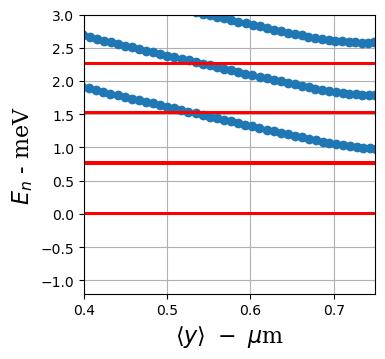

In [9]:
omB_00 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. )
omB_0 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_1 = omB - (4*np.pi*alpha*J)**2./(32.*J)*(2*1**2. + 2.*1 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_2 = omB*2 - (4*np.pi*alpha*J)**2./(32.*J)*(2*2**2. + 2.*2 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_3 = omB*3 - (4*np.pi*alpha*J)**2./(32.*J)*(2*3**2. + 2.*3 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

mid_y = np.amax(np.abs(np.diagonal(XXX)))/2.*0

plt.figure(figsize=(16, 8))

plt.plot( (np.abs(np.diagonal(XXX)) -mid_y)*l0, (evals.real + 4*J - omB_00/2.)*BandW0/8, linestyle='none', marker='o')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_3)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_2)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(omB_1)*BandW0/8, color='red', linestyle='-')
plt.plot((np.abs(np.diagonal(XXX)) -mid_y)*l0, np.ones(np.abs(np.diagonal(XXX)).size)*(0)*BandW0/8, color='red', linestyle='-')
#plt.plot(Xvec, evals.real, linestyle='none', marker='o')
plt.xlim((.4, .75 ))
plt.ylim((-1.2,3))
plt.grid()

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel(r'$\langle{ y \rangle} ~ - ~ \mu$m', fontdict=font)
plt.ylabel(r'$E_n$ - meV', fontdict=font)


plt.tight_layout()
plt.gcf().set_size_inches(80 / 25.4, 80 / 25.4)
#plt.savefig('LL_IMG%.2f_dis%.2f_xic%.2f_BW%.2f_alpha%.2f_Nx%dNy%d.svg' % (IMG, dis, xic, BandW0, alpha, Nx, Ny))
#plt.savefig('LL_IMG%.2f_dis%.2f_xic%.2f_BW%.2f_alpha%.2f_Nx%dNy%d.pdf' % (IMG, dis, xic, BandW0, alpha, Nx, Ny))

plt.show()

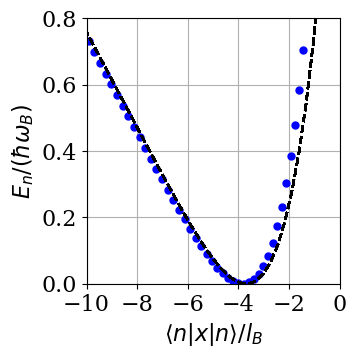

In [22]:

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']


omB_00 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. )
omB_0 = omB - (4*np.pi*alpha*J)**2./(32.*J)*( 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_1 = omB - (4*np.pi*alpha*J)**2./(32.*J)*(2*1**2. + 2.*1 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_2 = omB*2 - (4*np.pi*alpha*J)**2./(32.*J)*(2*2**2. + 2.*2 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2
omB_3 = omB*3 - (4*np.pi*alpha*J)**2./(32.*J)*(2*3**2. + 2.*3 + 1. ) + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

mid_y = np.amax(np.abs(np.diagonal(XXX)))/2.


fig, (ax1) = plt.subplots(1, 1, figsize=(170 / 25.4, 70 / 25.4))  # 240 mm by 80 mm figure



min_plot = np.amin( (evals.real + 4*J - omB_00/2.)/omB_1 )
Vtot = (omegaE + omega_conf - np.amin(omegaE + omega_conf))/omB_1

ax1.plot((np.abs(np.diagonal(XXX)) - mid_y)*l0/l_B-10, (evals.real + 4*J - omB_00/2.)/omB_1-min_plot, linestyle='none', color='blue', marker='o', ms=5)
ax1.plot((R[:,0] - mid_y)*l0/l_B-10, Vtot, linestyle='--', color='black')

ax1.set_xticks(np.arange(-10, 1, 2))  # X-ticks every 1
ax1.set_yticks(np.arange(0., 1.2, 0.2))  # Y-ticks every 0.5
ax1.set_xlim((-10, 0))
ax1.set_ylim((-.0, .8))
ax1.grid()


ax1.set_xlabel(r'$\langle{n| x|n \rangle}/l_B$', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})
ax1.set_ylabel(r'$E_n/(\hbar\omega_B)$', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})


# Adjust layout and display the figure
plt.tight_layout()
plt.gcf().set_size_inches(80 / 25.4, 120 / 25.4)

#plt.savefig('spec_alpha80_Nx100_Ny100.svg')
plt.show()

In [11]:
indx_1 = int( np.argmin(np.abs((evals.real + 4*J - omB_00/2.)/omB_1-min_plot - .12)) )
indx_2 = int( np.argmin(np.abs((evals.real + 4*J - omB_00/2.)/omB_1-min_plot - .13)) )

wM1 = np.zeros(shape=(Ny,Nx), dtype=np.complex_)
wM2 = np.zeros(shape=(Ny,Nx), dtype=np.complex_)
for n in range(len(R[:,0])):
    nx = int(R[n,0])
    ny = int(R[n,1])
    wM1[ny][nx] = evecs[n,indx_1]


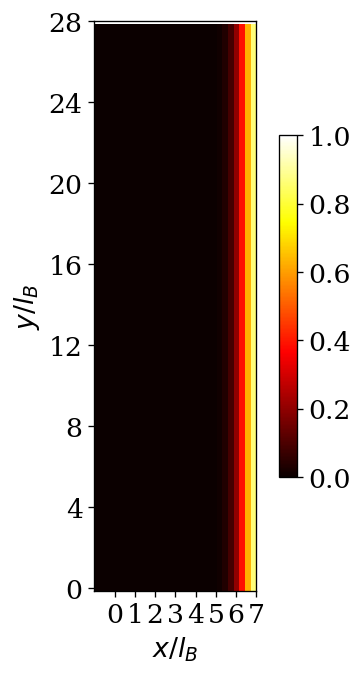

In [12]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('blue_white_red', ['blue', 'white', 'red'])


# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']


# Create vectors and meshgrid
xvec = np.linspace(0, Nx-1, int(Nx))
yvec = np.linspace(0, Ny-1, int(Ny))
X, Y = np.meshgrid(xvec, yvec)

# Plotting
fig_W, ax_W = plt.subplots(dpi=120, figsize=(4, 4))
vmin = 0  # Set the minimum value for colormap
vmax = 1.   # Set the maximum value for colormap
xmid = (np.amax(X*l0/l_B)-np.amin(X*l0/l_B))
Wmap_plot = ax_W.pcolormesh( X*l0/l_B - xmid/2, Y*l0/l_B, np.abs(wM1)**2/np.amax(np.abs(wM1)**2), cmap='hot', alpha=1, vmin=vmin, vmax=vmax)
cbar = fig_W.colorbar(Wmap_plot,shrink=0.6)
#cbar.set_label(r'$V_{\rm dis}$ - meV', fontdict=font)  # Add label to colorbar

# Axis labels
ax_W.set_xlabel(r'$x/l_B$', fontdict=font)
ax_W.set_ylabel(r'$y/l_B$', fontdict=font)
ax_W.set_aspect('equal')

ax_W.set_xticks(np.arange(0, 10, 1))  # X-ticks every 1
ax_W.set_yticks(np.arange(0, Ny*l0/l_B, 4))  # Y-ticks every 4

plt.tight_layout()
plt.gcf().set_size_inches(150 / 25.4, 150 / 25.4)

plt.xlim((-1,7))

#plt.savefig('pbc1_0.17_wave.pdf')
#plt.savefig('pbc1_0.17_wave.svg')
#plt.savefig('pbc1_0.17_wave.png', dpi=300)

# Show plot
plt.show()

(0.0, 14.741463549646515)

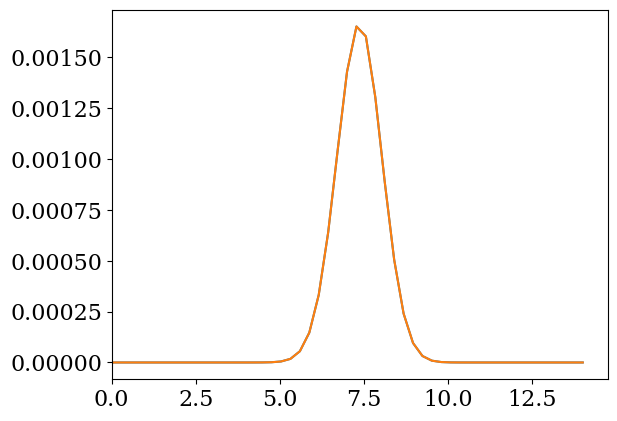

In [13]:
proj_x = np.zeros( shape=(len(R[:,0]), len(R[:,0]) ) )
count = 0
for n1 in range(len(R[:,0])):
    if np.abs(R[n1][1]) < 0.1:
        proj_x[n1][n1] = 1
        count += 1

proR = np.matmul(proj_x,R[:,0])
proE1 = np.matmul(proj_x, evecs[:,indx_1])
proE2 = np.matmul(proj_x, evecs[:,indx_2])
plt.plot( proR[0:count]*l0/l_B - mid_y*l0/l_B, np.abs(proE1[0:count])**2 )
plt.plot( proR[0:count]*l0/l_B - mid_y*l0/l_B, np.abs(proE2[0:count])**2 )

plt.xlim((0, mid_y*l0/l_B+1))

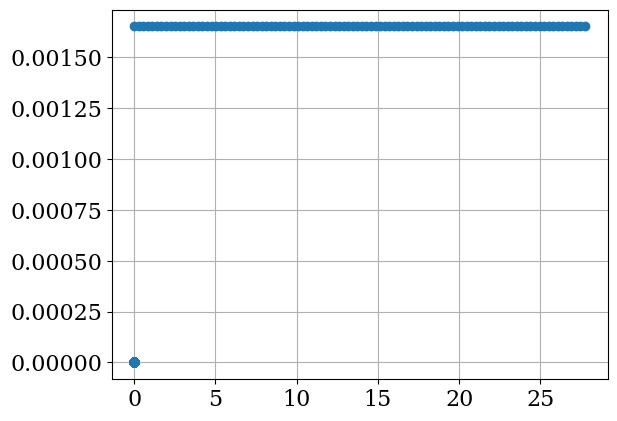

In [14]:
Xarr = np.diagonal(XXX)
proj_y1 = np.zeros( shape=(len(R[:,1]), len(R[:,1]) ) )
count1 = 0
for n1 in range(len(R[:,0])):
    if np.abs(R[n1][0] - Xarr[indx_1] ) < 0.4:
        proj_y1[n1][n1] = 1
        count1 += 1
proj_y2 = np.zeros( shape=(len(R[:,1]), len(R[:,1]) ) )
count2 = 0
for n1 in range(len(R[:,0])):
    if np.abs(R[n1][0] - Xarr[indx_2] ) < 0.4:
        proj_y2[n1][n1] = 1
        count2 += 1

proR1 = np.matmul(proj_y1,R[:,1])
proR2 = np.matmul(proj_y2,R[:,1])
proE1 = np.matmul(proj_y1, evecs[:,indx_1])
proE2 = np.matmul(proj_y2, evecs[:,indx_2])
plt.plot( proR1*l0/l_B, np.abs(proE1)**2, marker='o', linestyle='none' )
#plt.plot( proR2[0:count2]*l0/l_B, np.abs(proE2[0:count2])**2 )

#plt.ylim((0.00, .003))
plt.grid()

In [15]:
print(np.argmin(np.abs(R[:,0] - Xarr[indx_1] )))
print(Xarr[indx_1])

75
(75.29912199053871+7.663292033624467e-17j)


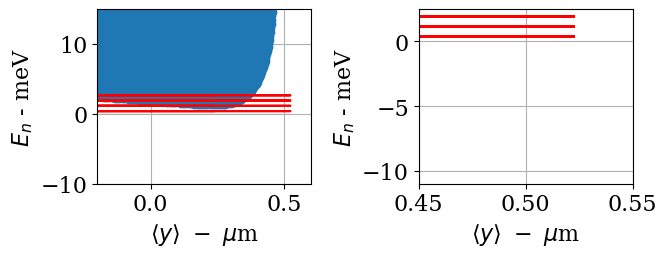

In [16]:
omB_0 = omB - (4 * np.pi * alpha * J)**2 / (32. * J) * 1
omB_1 = omB - (4 * np.pi * alpha * J)**2 / (32. * J) * (2 * 1**2 + 2 * 1 + 1)
omB_2 = omB * 2 - (4 * np.pi * alpha * J)**2 / (32. * J) * (2 * 2**2 + 2 * 2 + 1)
omB_3 = omB * 3 - (4 * np.pi * alpha * J)**2 / (32. * J) * (2 * 3**2 + 2 * 3 + 1)

mid_y = np.amax(np.abs(np.diagonal(XXX))) / 2.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))

font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16}

# Plot 1
ax1.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, (evals.real + 4 * J) * BandW0 / 8, linestyle='none', marker='o')
ax1.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_3) * BandW0 / 8, color='red', linestyle='-')
ax1.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_2) * BandW0 / 8, color='red', linestyle='-')
ax1.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_1) * BandW0 / 8, color='red', linestyle='-')
ax1.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2) * BandW0 / 8, color='red', linestyle='-')
ax1.set_xlim((-.2, .6))
ax1.set_ylim((-10., 15))
ax1.set_xlabel(r'$\langle{ y \rangle} ~ - ~ \mu$m', fontdict=font)
ax1.set_ylabel(r'$E_n$ - meV', fontdict=font)
ax1.grid()

# Plot 2
ax2.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, (evals.real + 4 * J) * BandW0 / 8, linestyle='none', marker='o')
ax2.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_3) * BandW0 / 8, color='red', linestyle='-')
ax2.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_2) * BandW0 / 8, color='red', linestyle='-')
ax2.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2 + omB_1) * BandW0 / 8, color='red', linestyle='-')
ax2.plot((np.abs(np.diagonal(XXX)) - mid_y) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_0 / 2) * BandW0 / 8, color='red', linestyle='-')
ax2.set_xlim((0.45, .55))
ax2.set_ylim((-11., 2.5))
ax2.set_xlabel(r'$\langle{ y \rangle} ~ - ~ \mu$m', fontdict=font)
ax2.set_ylabel(r'$E_n$ - meV', fontdict=font)
ax2.grid()

plt.tight_layout()
fig.set_size_inches(170 / 25.4, 100 / 25.4)
plt.savefig('spectrum_image_example_alpha%.2f_dis%.3f_xic%.2f_IMG%.2f_BandW0%.2f_Nx%dNy%d.svg' % (alpha, dis, xic, IMG, BandW0, Nx, Ny) )
plt.savefig('spectrum_image_example_alpha%.2f_dis%.3f_xic%.2f_IMG%.2f_BandW0%.2f_Nx%dNy%d.pdf' % (alpha, dis, xic, IMG, BandW0, Nx, Ny) )

plt.show()